# Identificando Importância de Variáveis nos Modelos de Curto Prazo da Inflação

Com a finalidade de aplicar um método que fosse aplicável entre diferentes modelos para identificar a importância de variáveis (Feature Importance) e selecionar as mais relevantes (Feature Selection) para compor os modelos de curto prazo da GEASE, foi aplicada metodologia baseada em modelo de Regressão com penalização (Shrinkage Regression).

Optou-se por utilizar o modelo Elastic NET tendo em vista algumas limitaçãoes do modelo LASSO e Ridge e suas adaptações.

## Modelo Elastic Net

De acordo com alguns autores, uma desvantagem dos algoritmos LASSO e Ridge é sua eficácia limitada ao lidar com variáveis ​​altamente correlacionadas. Nos casos em que certas variáveis ​​explicativas apresentam correlações fortes, o estimador LASSO pode tratá-las com indiferença, enquanto o estimador Ridge tende a reduzi-las coletivamente e não eliminá-las. Além disso, conforme mostrado por Wang et al., 2020 em sua simulação, a regularização $l_{1}$ tende a introduzir muitas variáveis ​​espúrias em modelos muito esparsos. 

Com o intuito de contornar esses problemas, optou-se por aulizar o modelo Elastic Net que contorna esses problemas empregando uma função de penalidade com dois termos de ajuste. O termo inicial dentro da função de penalidade promove a seleção esparsa de variáveis, enquanto o segundo termo incentiva a média dos coeficientes. Assim, o Elastic Net, apresentada por  Zou & Hastie, 2005, introduz um componente de penalidade que mescla as penalidades de Ridge e LASSO usando uma mistura convexa:

\begin{equation}
\lambda p(\beta)=\lambda\left[(1-\alpha)\|\beta\|_{2}^{2}+\alpha\|\beta\|_{1}\right]
\end{equation}

Neste método, o hiperparâmetro $\lambda$ controla a força geral da penalidade, enquanto um novo hiperparâmetro $\alpha$ determina a importância relativa das penalidades $l_{1}$ e $l_{2}$. Notavelmente, quando $\alpha=0$, a penalidade se reduz à regressão Ridge, e quando $\alpha=1$, torna-se equivalente ao LASSO. Este termo de penalidade modificado proporciona uma melhoria em relação ao LASSO em cenários que envolvem preditores altamente correlacionados. Incentiva um efeito de agrupamento, onde preditores fortemente correlacionados têm maior probabilidade de serem selecionados ou excluídos do modelo.

Resumindo, LASSO e Elastic Net Regression são úteis para seleção de variáveis em conjuntos de dados complexos devido à sua característica de efeito de esparsidade. Porém, devido à capacidade do Elastic Net de lidar com características correlacionadas e nosso conjunto de dados possuir muitas séries temporais com essa característica, optamos por trabalhar com esse modelo para selecionar nossas variáveis. 

Esse método de redução equilibra a precisão do modelo com a complexidade, o que é crucial na modelagem estatística e no aprendizado de máquina. Contudo, a interpretação final do modelo deve sempre considerar o conhecimento e o contexto do domínio. Esses métodos são benéficos em cenários de dados de alta dimensão, onde a compreensão dos relacionamentos variáveis ​​é crítica.

### Bibliotecas

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

### Carga de dados

In [2]:
# Load the dataset
file_path = 'stationarity_accepted.csv'
data = pd.read_csv(file_path, delimiter=',')
#data = data.drop("Unnamed: 0", axis=1)

# Convert 'data' column to datetime and set as index
data['data'] = pd.to_datetime(data['data'])#, format='%d/%m/%Y')
data.set_index('data', inplace=True)

# Exclude variables that start with "var_ipca_bacen_lag"
columns_to_keep = [col for col in data if not col.startswith("var_ipca_bacen_lag")]
# Select only the desired columns
data = data[columns_to_keep]

# Choose a specific date range (e.g., from '2022-01-01' to '2022-01-31')
start_date = '2010-01-08'
end_date = '2024-01-01'
data = data.loc[start_date:end_date]

# Display the first few rows of the dataset
data.tail()

,var_ipc_fipe,var_ipca_15,var_ipc_br,ipca_monitor_1,ipca_monitor_11,ipca_monitor_2,ipca_monitor_5,ipca_monitor_6,ipca_monitor_8,ipca_monitor_9,...,caged_saldo_norte_1_diff_lag4,caged_saldo_nordeste_1_diff_lag4,caged_saldo_sudeste_1_diff_lag4,caged_saldo_sul_1_diff_lag4,caged_saldo_centro_oeste_1_diff_lag4,caged_saldo_brasil_1_diff_lag4,base_monetaria_2_diff_lag4,base_monetaria_log_2_diff_lag4,PNAD_DESOC_2_diff_lag4,var_ipca_bacen
data,,,,,,,,,,,,,,,,,,,,,
2023-01-09,0.29,0.35,0.27,-0.480,-0.770,0.286522,1.560870,-0.11,0.041739,-0.32,...,1784,3517,-3501,-19057,-10529,-24735,-587062,-0.001483,-0.157911,0.26
2023-01-10,0.30,0.21,0.45,0.050,0.050,0.025200,0.518000,0.86,0.026400,0.04,...,1481,18941,-26668,717,7074,1928,1916457,0.004834,-0.293487,0.24
2023-01-11,0.43,0.33,0.27,0.905,1.205,0.411818,0.503182,-0.72,0.038636,-0.12,...,651,-1569,-5876,-2312,-3237,-14496,5278276,0.013194,-0.139769,0.28
2023-01-12,0.38,0.40,0.29,0.940,1.160,0.255217,-0.120870,-0.47,0.025217,-0.23,...,3096,31719,29801,15556,-433,78142,45677,0.000113,-0.116411,0.56
2024-01-01,0.46,0.31,0.61,1.780,2.260,0.290800,0.178400,0.54,0.531600,0.18,...,-1002,11334,-17656,-501,-3084,-9080,-2694341,-0.006712,-0.094243,0.42


### Treino e Teste

In [3]:

# Define the target variable and the features
target = 'var_ipca_bacen'
X = data.drop(target, axis=1)
y = data[target]

# Calculate the split point based on the desired percentage (e.g., 80% for training)
split_point = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Check the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Optionally, you can check the first few rows of y_test and the last few rows of y_train
print("\nFirst few rows of y_test:")
print(y_test.head())

print("\nLast few rows of y_train:")
print(y_train.tail())


X_train shape: (129, 155)
X_test shape: (33, 155)
y_train shape: (129,)
y_test shape: (33,)

First few rows of y_test:
data
2021-01-05    0.83
2021-01-06    0.53
2021-01-07    0.96
2021-01-08    0.87
2021-01-09    1.16
Name: var_ipca_bacen, dtype: float64

Last few rows of y_train:
data
2020-01-12    1.35
2021-01-01    0.25
2021-01-02    0.86
2021-01-03    0.93
2021-01-04    0.31
Name: var_ipca_bacen, dtype: float64


### Validação Cruzada (Cross Validation)

In [4]:
# Define the cross-validator
tscv = TimeSeriesSplit(n_splits=10)

### Scaling

In [5]:
# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define the parameter grid
# param_grid = {
#     'alpha': [0.1, 1.0, 10.0],  # List of alpha values to try
#     'l1_ratio': [0.1, 0.5, 0.9]  # List of l1_ratio values to try
#  }

#Define the parameter grid
# param_grid = {
#      'alpha': np.logspace(-3, 3, 7),  # Ranges from 0.001 to 1000 logarithmically
#      'l1_ratio': np.linspace(0.01, 0.6, 9)  # Ranges from 0.1 to 0.9 linearly
#  }


#Define the parameter grid
param_grid = {
     'alpha': np.linspace(0.02, 0.9, 9),  # Ranges from 0.02 to 0.9 linearly
     'l1_ratio': np.linspace(0.02, 0.9, 9)  # Ranges from 0.02 to 0.9 linearly
 }

# Instantiate ElasticNet model
elastic_net = ElasticNet()

### Grid Search Hiperparamêtros (Hyperparameter Grid Search)

In [6]:
# Create GridSearchCV object
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding MSE score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model using the best parameters
best_elastic_net = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
best_elastic_net.fit(X_train_scaled, y_train)


ElasticNet(alpha=0.02, l1_ratio=0.13)

#### Gráfico Grid Search (Chart showing the best Alpha and Lambda)

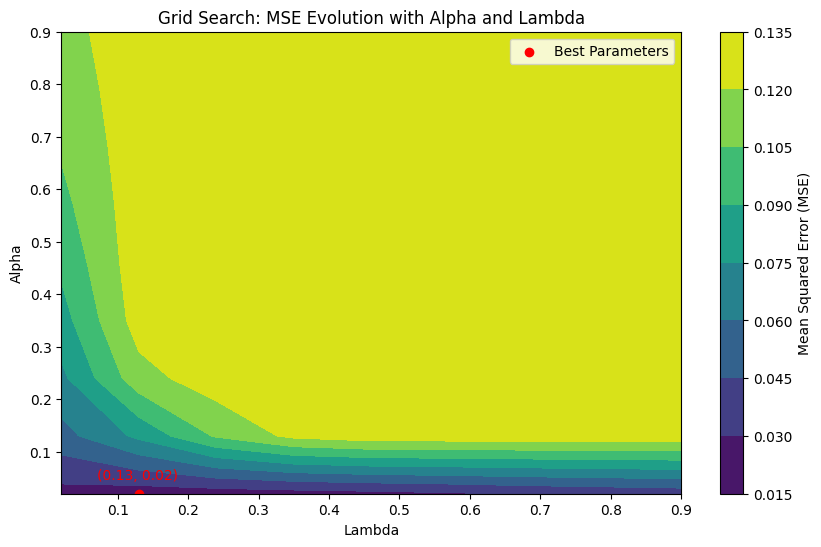

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting grid search results
results = grid_search.cv_results_
alphas = np.array(param_grid['alpha'])
l1_ratios = np.array(param_grid['l1_ratio'])
mse_values = -results['mean_test_score'].reshape(len(alphas), len(l1_ratios))

# Get the best alpha and lambda
best_alpha = best_params['alpha']
best_lambda = best_params['l1_ratio']

# Create a contour plot
plt.figure(figsize=(10, 6))
plt.contourf(l1_ratios, alphas, mse_values, cmap='viridis')
plt.colorbar(label='Mean Squared Error (MSE)')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.title('Grid Search: MSE Evolution with Alpha and Lambda')

# Highlight the best point
plt.scatter(best_lambda, best_alpha, color='red', marker='o', label='Best Parameters')
plt.annotate(f'({best_lambda:.2f}, {best_alpha})', xy=(best_lambda, best_alpha), xytext=(-30, 10), textcoords='offset points', fontsize=10, color='red')
plt.legend()

plt.show()



### Previsão (Predict)

In [8]:
# Predict on the testing set
y_pred = best_elastic_net.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R2
r2 = r2_score(y_test, y_pred)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Squared Error (MSE): 0.030500857578435563
Root Mean Squared Error (RMSE): 0.17464494718839008
R-squared (R2): 0.8617852629066022
Mean Absolute Error (MAE): 0.13030990303836038
Mean Absolute Percentage Error (MAPE): 24.68597129595911


### Coeficientes Selecionados

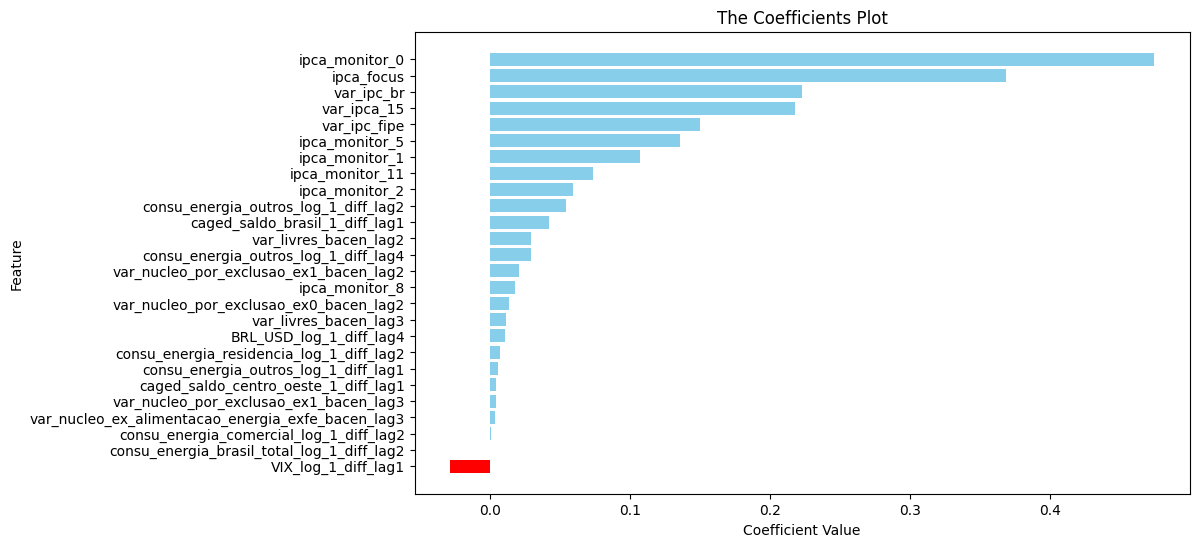

In [9]:

# Get feature coefficients
coefficients = best_elastic_net.coef_

# Get the non-zero coefficients and their corresponding features
nonzero_coefficients = coefficients[coefficients != 0]
nonzero_features = X.columns[coefficients != 0]

# Create a DataFrame to store feature names and their coefficients
coefficients_df = pd.DataFrame({'Feature': nonzero_features, 'Coefficient': nonzero_coefficients})

# Sort the DataFrame by coefficients
coefficients_df_sorted = coefficients_df.sort_values(by='Coefficient')

# Get the top 20 features with the highest coefficients
top_20 = coefficients_df_sorted.tail(50)

# Get the 20 features with the lowest coefficients
bottom_20 = coefficients_df_sorted.head(50)

# Concatenate top 20 and bottom 20
selected_features = pd.concat([top_20, bottom_20])

# Plot the selected features
plt.figure(figsize=(10, 6))
colors = ['red' if coeff < 0 else 'skyblue' for coeff in selected_features['Coefficient']]
plt.barh(selected_features['Feature'], selected_features['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('The Coefficients Plot')
plt.show()


### Variable Selected

In [10]:
coefficients_df_sorted

,Feature,Coefficient
10,VIX_log_1_diff_lag1,-0.028501
17,consu_energia_brasil_total_log_1_diff_lag2,0.000146
19,consu_energia_comercial_log_1_diff_lag2,0.000728
23,var_nucleo_ex_alimentacao_energia_exfe_bacen_lag3,0.003988
22,var_nucleo_por_exclusao_ex1_bacen_lag3,0.004544
12,caged_saldo_centro_oeste_1_diff_lag1,0.004728
11,consu_energia_outros_log_1_diff_lag1,0.005653
18,consu_energia_residencia_log_1_diff_lag2,0.007681
24,BRL_USD_log_1_diff_lag4,0.011096
21,var_livres_bacen_lag3,0.011852


O gráfico e tabela acima fornece os nomes e coeficientes correspondentes para cada variável selecionada, conforme determinado pelos resultados do Elastic Net. Oito das 26 variáveis representam dados de séries temporais associados à economia real ou aos mercados financeiros. Estes incluem indicadores do mercado de trabalho brasileiro (CAGED), taxa de câmbio nominal (BRL/USD), consumo de energia e métricas financeiras (VIX). Vale a pena notar que todos essas variáveis exibem algum grau de atraso (lag) \footnote{Aplicamos até 4 atrasos (lags) a essas variáveis conforme recomenda a literatura.}. 

É imperativo sublinhar que qualquer indicador sobre a economia real ou os mercados financeiros no nosso estudo carrega inerentemente uma defasagem, mesmo quando a série temporal é contemporânea ao IPCA. Por exemplo, para o VIX e taxa de câmbio nominal, temos o indicador para o mesmo mês de referência do IPCA, mas a Elastic Net selecionou seus valores defasados. Por outro lado, algumas variáveis não são divulgadas contemporaneamete ao IPCA, como séries temporais relacionadas ao mercado de trabalho e ao consumo de energia. 

Essas variáveis defasadas selecionadas alinham-se com a observação de que os modelos de inflação, particularmente em economias emergentes como o Brasil, deveriam incorporar uma rica estrutura de defasagem devido à inércia da inflação, conforme destacado por Araujo & Gaglianone, 2023. Além disso, indicadores econômicos especificos, como o consumo de energia e as taxas de câmbio, foram previamente identificados por Özgür & Akkoç, 2021 no seu estudo sobre a previsão da inflação na Turquia utilizando métodos de Regressão com Penalização para realizar seleção de variáveis, demonstrando a sua relevância em diferentes países.

A maioria das variáveis selecionadas, totalizando 18, está intimamente associada à variável-alvo (IPCA). Por exemplo, métricas de núcleo da inflação \footnote{Dependendo do indicador, excluem itens específicos da cesta de bens para criar um novo indicador relacionado ao índice de preços ao consumidor.} junto com o IPCA defasado e outras métricas mensais de inflação no Brasil divulgadas antes do IPCA (IPC-FIPE, IPCA-15,etc). 

O coeficiente mais significativo corresponde a uma série temporal derivada do "Monitor da Inflação"\footnote{Trata-se de um acompanhamento diário da evolução dos preços no consumidor. Esse serviço gera estimativas diárias do IPCA, índice oficial de inflação do país, que é de responsabilidade do IBGE. O sistema de cálculo também disponibiliza os resultados do IPC-FGV com a mesma periodicidade. Mais informações podem ser encontradas na https://portalibre.fgv.br/monitor-da-inflacao} base de dados disponibilizada pelo IBRE/FGV. O objetivo é replicar a metodologia do IPCA, fornecendo estimativas quase em tempo real com base nas variações reais dos preços. 

Todas as variáveis que utilizam dados do “Monitor da Inflação” influenciaram significativamente o modelo com  coeficientes elevados. Para distingui-los, incorporamos a string "monitor" em seus nomes\footnote{Geramos um total de 12 indicadores, mas apenas oito demonstraram estacionariedade em nossos testes, conforme detalhado no Apêndice \ref{apendiceB}. Seguindo um processo de seleção de variáveis por meio do Elastic Net, foram escolhidos seis indicadores, a saber: "ipca\_monitor\_0," "ipca\_monitor\_5," "ipca\_monitor\_1," "ipca\_monitor\_11," "ipca\ _monitor\_2," e "ipca\_monitor\_8." Os coeficientes associados a estes indicadores podem ser encontrados no Apêndice \ref{apendiceC}.}. Esses indicadores são grupos do \acrshort{IPCA} \footnote{"Transporte" ("ipca\_monitor\_5"), "Grupo Alimentos e Bebidas" ("ipca\_monitor\_1"), "Comida em Casa" ("ipca \_monitor\_11"), "Habitação" ou "Abrigo" ("ipca\_monitor\_2"), "Educação" ("ipca\_monitor\_8").}, e o nível de importância das variáveis reflete seu peso no mercado brasileiro para o IPCA. Por exemplo, os gastos mensais nos grupos “Transporte” e “Alimentos e Bebidas” impactaram significativamente nossa meta.

O segundo coeficiente mais significativo está relacionado ao Focus \footnote{Segundo o \acrshort{BCB}, “o Focus resume as estatísticas calculadas sobre as expectativas do mercado coletadas até a sexta-feira anterior. expectativas de mercado para índices de preços, atividade econômica, taxa de câmbio e taxa Selic, entre outros. As expectativas são fornecidas por analistas de mercado, e não pelo próprio \acrshort{BCB}".} previsões para o nosso alvo sendo a mediana da expectativa de mercado do alvo em mensalmente. Ele se correlaciona significativamente com o alvo e a importância desse recurso é razoavelmente explicada. A terceira (\acrshort{IPC-BR}), a quarta (\acrshort{IPCA-15}) e a quinta (\acrshort{IPC-FIPE}) características mais significativas são outros tipos de métricas de inflação de preços ao consumidor no Brasil. são contemporâneos ao alvo, portanto, não possuem defasagem em seus nomes como outras características.

É fundamental destacar que o alvo com duas e três defasagens \footnote{São "var\_ipca\_bacen\_lag3" e "var\_ipca\_bacen\_lag2".} foi selecionado. Embora não tenham o nível mais significativo, desempenham algum papel na

In [ ]:
coefficients

In [ ]:
# Filter coefficients with absolute values higher than 0
filtered_coef_elastic_net = coefficients_df
filtered_coef_elastic_net.to_csv('filtered_coef_elastic_net.csv', index=False)

# Assuming "data" is your original DataFrame, you can extract the relevant columns using the feature names
#filtered_data_elastic_net = data[filtered_coef_elastic_net['Feature']]
#Extract the target column from dataframe 'data' and assign it to the dataframe 'filtered_data_elastic_net'.
#filtered_data_elastic_net['var_ipca_bacen'] = data['var_ipca_bacen']
# Extract the 'data' column from dataframe 'data' and assign it to the dataframe 'filtered_data_elastic_net'.
#filtered_data_elastic_net['data'] = data.index


# Extract the relevant columns using the feature names
filtered_data_elastic_net = data.loc[:, filtered_coef_elastic_net['Feature']]

# Extract the target column from dataframe 'data' and assign it to the dataframe 'filtered_data_elastic_net'.
filtered_data_elastic_net['var_ipca_bacen'] = data.loc[:, 'var_ipca_bacen']

# Extract the 'data' column from dataframe 'data' and assign it to the dataframe 'filtered_data_elastic_net'.
filtered_data_elastic_net['data'] = data.index


# Now, you can save the filtered data to a CSV file
filtered_data_elastic_net.to_csv('filtered_data_elastic_net.csv', index=False)

# Now, you can save the filtered data columns names to a CSV file
column_names = pd.DataFrame(list(filtered_data_elastic_net.columns.values))
column_names
column_names.to_csv('column_names_elastic_net.csv', index=False)